# Introduction

How much does what is included in the annotation set matter?

In [1]:
import seaborn
import scipy
import scipy.stats
import scipy.optimize
import anndata
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot, cm
import sys
import pysam
from collections import Counter
from IPython import display

import upsetplot

In [2]:
pandas.options.display.max_rows = 300

In [3]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [4]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [5]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type

def calculate_v29_gene_base(gene_id):
    gene_base = gene_id.split('.')[0]
    if gene_id.endswith("_PAR_Y"):
        gene_base += "_PAR_Y"
    return gene_base
v29_gtf['gene_base'] = v29_gtf['gene_id'].apply(calculate_v29_gene_base)

In [6]:
v32m_genome_dir = Path("~/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/").expanduser()
v32m_store = pandas.HDFStore(v32m_genome_dir / "GRCh38-arc2.0-2.7.8a" / "GRCh38-arc2.0-2.7.8a.h5")
v32m_gtf = v32m_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v32m_store.close()

v32m_gtf.columns = ['gene_base', 'gene_name', 'gene_type']
v32m_gtf['gene_id'] = v32m_gtf['gene_base'].apply(lambda x: v29_gene_base_to_id.get(x, x))

v32m_gene_id_to_name = {}
v32m_gene_id_to_type = {}
for i, row in v32m_gtf.iterrows():
    v32m_gene_id_to_name[row.gene_id] = row.gene_name
    v32m_gene_id_to_type[row.gene_id] = row.gene_type

In [7]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered", multiread="Unique"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "GeneFull_Ex50pAS", "SJ"]
    MULTIREAD_MATRIX = {
    "Unique": "matrix.mtx",
    "Rescue": "UniqueAndMult-Rescue.mtx",
    "EM": "UniqueAndMult-EM.mtx",
    }
    assert multiread in MULTIREAD_MATRIX

    analysis_dir = Path(analysis_dir)
    
    solo_dir = analysis_dir / "Solo.out" / quantification 
    solo = scanpy.read_mtx(solo_dir / "raw" / MULTIREAD_MATRIX[multiread]).T
    solo_vars = pandas.read_csv(
        solo_dir / "raw" / "features.tsv", header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "raw" / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]
    
    if mode == "filtered":
        solo_obs = pandas.read_csv(
            solo_dir / mode / "barcodes.tsv", header=None, sep="\t"
        ).values.T[0]
        solo = solo[solo_obs,:]
        

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



# Load Datasets

In [8]:
encode_full =  scanpy_load_solo278a_mtx(Path("fullsolo_multi_dev_EoI_2.7.9a_2021-09-10"), "GeneFull_Ex50pAS", "filtered", "EM")

Trying to set attribute `.obs` of view, copying.


... storing 'gene_name' as categorical
... storing 'gene_type' as categorical


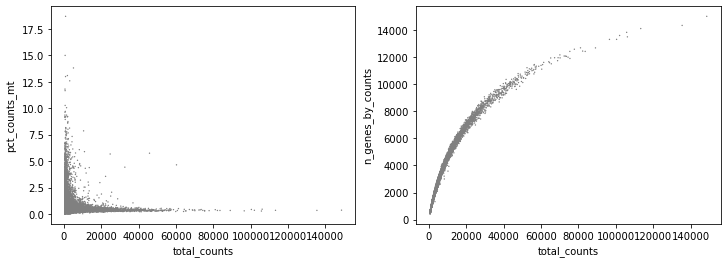

In [9]:
encode_full.var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in encode_full.var_names]
encode_full.var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in encode_full.var_names]
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)

In [10]:
v29_genome_dir = Path("~/proj/genome/").expanduser()
v29_store = pandas.HDFStore(v29_genome_dir / "GRCh38-V29-male" / "GRCh38-V29-male.h5")
v29_gtf = v29_store.select('/gtf', where='type == gene', columns=['gene_id', 'gene_name', 'gene_type'])
v29_store.close()

v29_gene_base_to_id = {}
v29_gene_id_to_name = {}
v29_gene_id_to_type = {}
for i, row in v29_gtf.iterrows():
    v29_gene_base_to_id[row.gene_id.split('.')[0]] = row.gene_id
    v29_gene_id_to_name[row.gene_id] = row.gene_name
    v29_gene_id_to_type[row.gene_id] = row.gene_type


# Lets try the scanpy tutorial

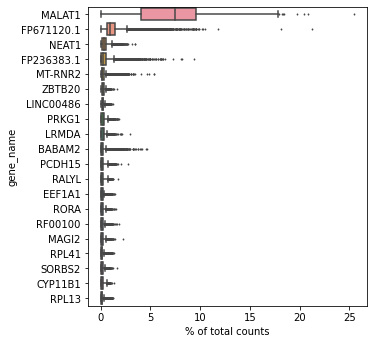

... storing 'gene_name' as categorical
... storing 'gene_type' as categorical
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/

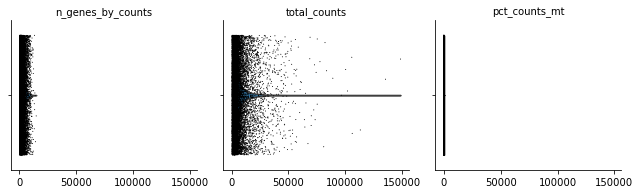

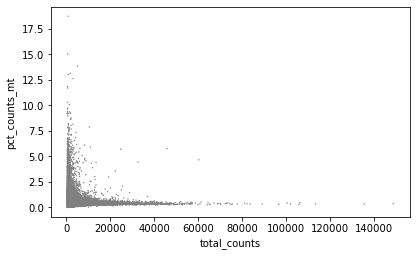

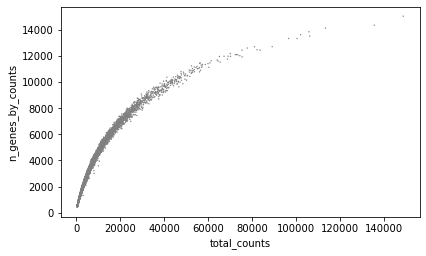

In [11]:

encode_full.var['gene_name'] = [v29_gene_id_to_name.get(x, x) for x in encode_full.var_names]
encode_full.var['gene_type'] = [v29_gene_id_to_type.get(x, x) for x in encode_full.var_names]

scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(encode_full, min_genes=200)
scanpy.pp.filter_genes(encode_full, min_cells=3)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
scanpy.pl.violin(
    encode_full,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt')
scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts')        

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


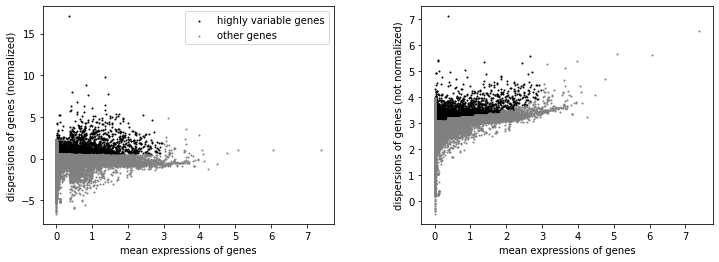

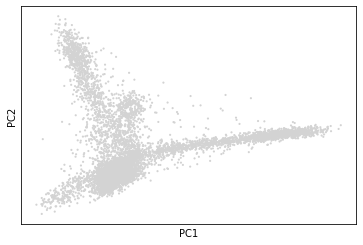

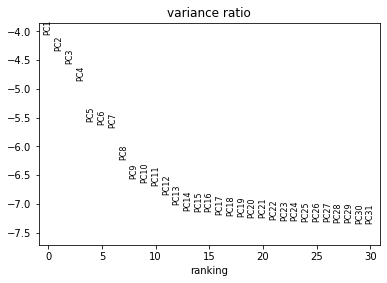

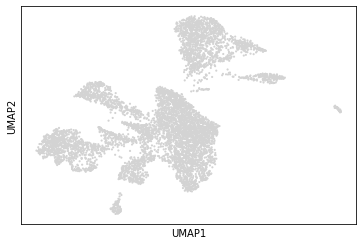

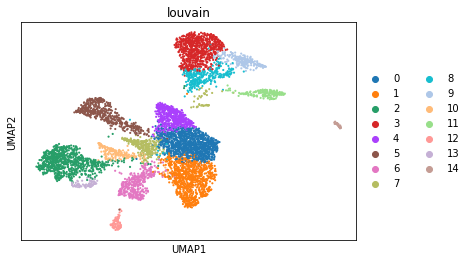

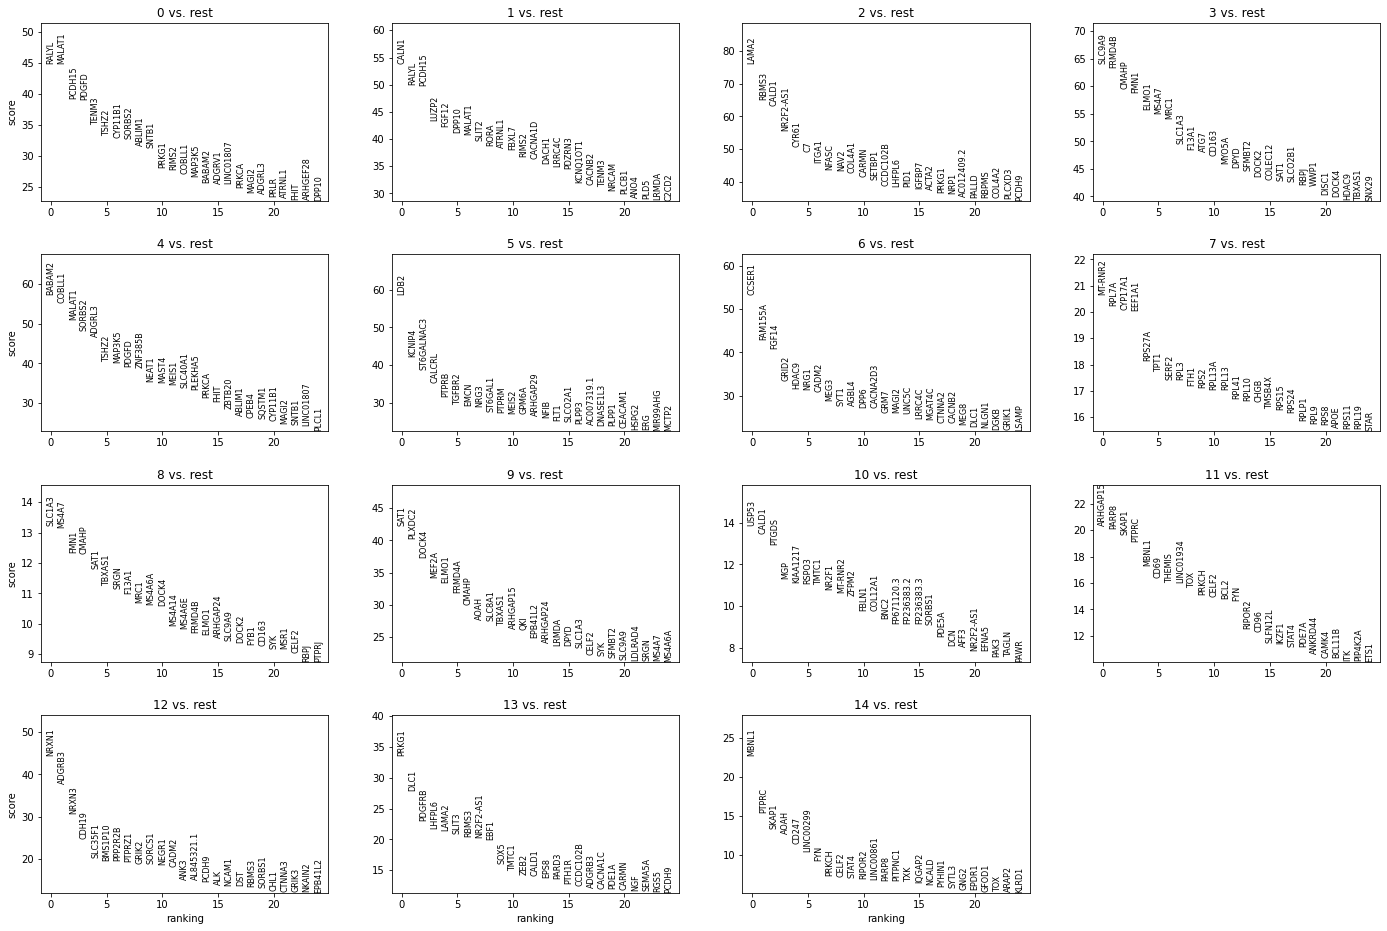

In [12]:
encode_full_filtered = encode_full[encode_full.obs.n_genes_by_counts < 2000, :]
encode_full_filtered = encode_full_filtered[encode_full_filtered.obs.pct_counts_mt < 2.5, :]

scanpy.pp.normalize_total(encode_full_filtered, target_sum=30000)
scanpy.pp.log1p(encode_full_filtered)
scanpy.pp.highly_variable_genes(encode_full_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(encode_full_filtered)
encode_full_filtered.raw = encode_full_filtered
encode_full_filtered = encode_full_filtered[:, encode_full_filtered.var.highly_variable]

scanpy.pp.regress_out( encode_full_filtered, ['total_counts', 'pct_counts_mt'])
scanpy.pp.scale( encode_full_filtered, max_value=10)
scanpy.tl.pca(encode_full_filtered, svd_solver='arpack')
scanpy.pl.pca(encode_full_filtered)

scanpy.pl.pca_variance_ratio(encode_full_filtered, log=True)

scanpy.pp.neighbors(encode_full_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(encode_full_filtered)
scanpy.pl.umap(encode_full_filtered)

scanpy.tl.louvain(encode_full_filtered)
scanpy.pl.umap(encode_full_filtered, color=['louvain'])

scanpy.tl.rank_genes_groups(encode_full_filtered, 'louvain', method='t-test')
scanpy.pl.rank_genes_groups(encode_full_filtered, n_genes=25, sharey=False, gene_symbols='gene_name')



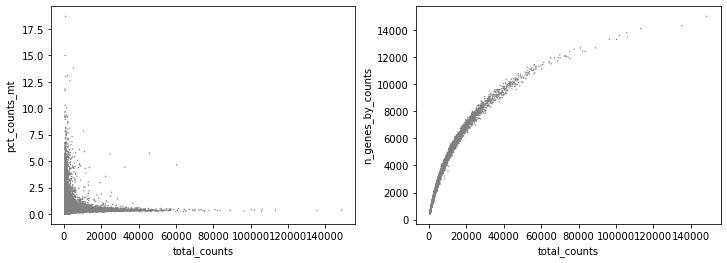

In [13]:
f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)

Text(0.5, 1.0, 'KDE of n genes by counts')

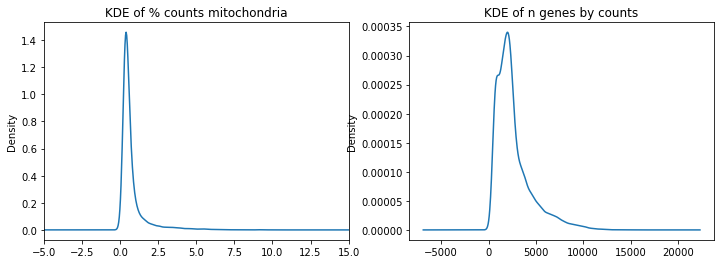

In [14]:
f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
ax = encode_full.obs["pct_counts_mt"].plot.kde(ax=ax)
ax.set_title("KDE of % counts mitochondria")
ax.set_xlim(-5, 15)

ax = f.add_subplot(1,2,2)
ax = encode_full.obs["n_genes_by_counts"].plot.kde()
ax.set_title("KDE of n genes by counts")

In [15]:
kde = scipy.stats.gaussian_kde(encode_full.obs["n_genes_by_counts"])

In [16]:
numpy.nanmin(encode_full.obs["pct_counts_mt"]), numpy.nanmax(encode_full.obs["pct_counts_mt"])

(0.0, 18.704285)

In [17]:
numpy.nanmin(encode_full.obs["n_genes_by_counts"]), numpy.nanmax(encode_full.obs["n_genes_by_counts"])

(410, 15023)

In [18]:
mean, stdev = scipy.stats.norm.fit(encode_full.obs["pct_counts_mt"])
mean - stdev, mean + 2*stdev

(-0.21597844, 2.6807214617729187)

In [19]:
mean, stdev = scipy.stats.norm.fit(encode_full.obs["n_genes_by_counts"])
mean - stdev, mean + 2*stdev

(695.5818943523766, 6482.03693704009)

Text(0.5, 1.0, 'KDE of n genes by counts')

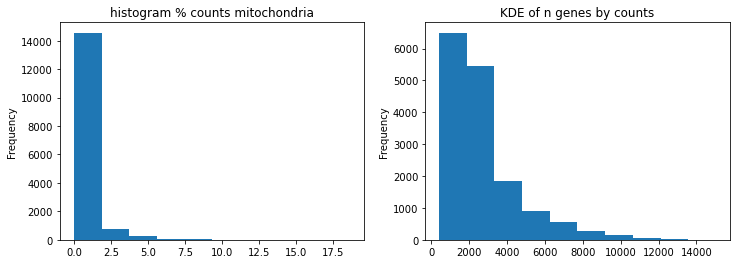

In [20]:
f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
ax.set_title("histogram % counts mitochondria")
ax = encode_full.obs["pct_counts_mt"].plot.hist(ax=ax)

ax = f.add_subplot(1,2,2)
ax = encode_full.obs["n_genes_by_counts"].plot.hist()
ax.set_title("KDE of n genes by counts")

In [21]:
pct_mt = 2.5
n_genes = 4000

/usr/lib/python3/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


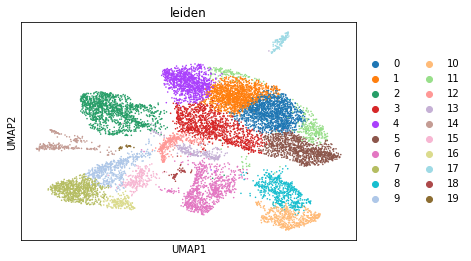

In [22]:

#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(encode_full, min_genes=200)
scanpy.pp.filter_genes(encode_full, min_cells=3)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#scanpy.pl.violin(
#    encode_full,
#    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#    jitter=0.4, multi_panel=True)
#scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt')
#scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts')        

hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]
scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)
scanpy.pp.highly_variable_genes(hist_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
#scanpy.pl.highly_variable_genes(hist_filtered)
hist_filtered.raw = hist_filtered
hist_filtered = hist_filtered[:, hist_filtered.var.highly_variable]


scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(hist_filtered)
#scanpy.pl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

In [23]:
mean, stdev = scipy.stats.norm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 2 * stdev
mean, stdev = scipy.stats.norm.fit(encode_full.obs["n_genes_by_counts"])
n_genes = mean + 2 * stdev
pct_mt, n_genes

(2.6807214617729187, 6482.03693704009)

2.6807214617729187 6482.03693704009


/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


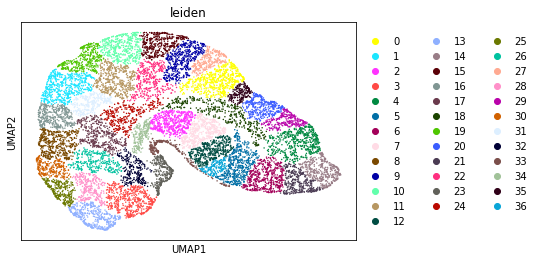

In [24]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(encode_full, min_genes=200)
scanpy.pp.filter_genes(encode_full, min_cells=3)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.norm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 2 * stdev
mean, stdev = scipy.stats.norm.fit(encode_full.obs["n_genes_by_counts"])
n_genes = mean + 2 * stdev
print(pct_mt, n_genes)

hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

#hist_filtered = encode_full.copy()

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)
scanpy.pp.highly_variable_genes(hist_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
#scanpy.pl.highly_variable_genes(hist_filtered)
hist_filtered.raw = hist_filtered
#hist_filtered = hist_filtered[:, hist_filtered.var.highly_variable]

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=30, n_pcs=2)
#scanpy.pp.neighbors(hist_filtered, knn=True)
scanpy.tl.umap(hist_filtered)
#scanpy.pl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

2.6807214617729187 6482.03693704009


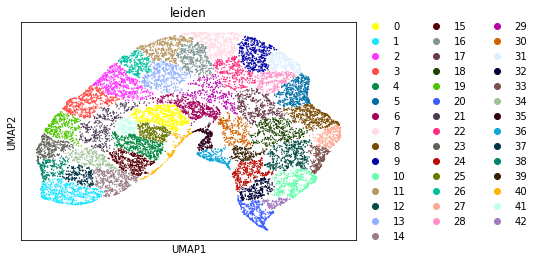

In [25]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(encode_full, min_genes=200)
scanpy.pp.filter_genes(encode_full, min_cells=3)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.norm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 2 * stdev
mean, stdev = scipy.stats.norm.fit(encode_full.obs["n_genes_by_counts"])
n_genes = mean + 2 * stdev
print(pct_mt, n_genes)

#hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
#hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

hist_filtered = encode_full.copy()

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)
scanpy.pp.highly_variable_genes(hist_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
#scanpy.pl.highly_variable_genes(hist_filtered)
hist_filtered.raw = hist_filtered
#hist_filtered = hist_filtered[:, hist_filtered.var.highly_variable]

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=30, n_pcs=2)
#scanpy.pp.neighbors(hist_filtered, knn=True)
scanpy.tl.umap(hist_filtered)
#scanpy.pl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

1.7151548266410828 8410.855284602661


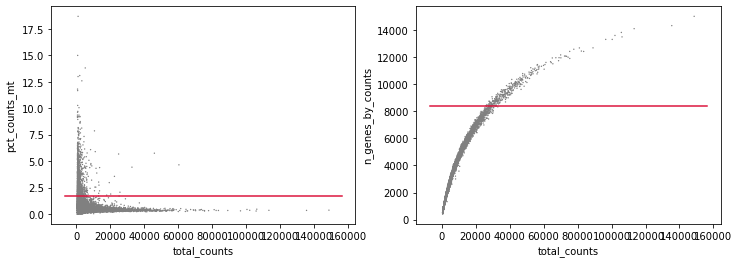

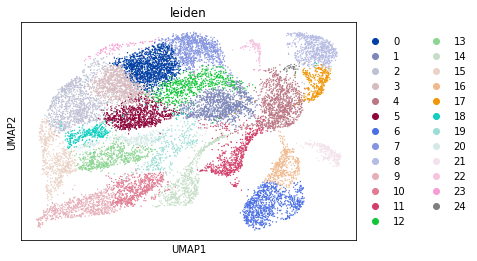

In [26]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
scanpy.pp.filter_cells(encode_full, min_genes=200)
scanpy.pp.filter_genes(encode_full, min_cells=3)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.norm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 1 * stdev
mean, stdev = scipy.stats.norm.fit(encode_full.obs["n_genes_by_counts"])
n_genes = mean + 3 * stdev
print(pct_mt, n_genes)


f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (pct_mt, pct_mt), color="#DC143C")
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (n_genes, n_genes), color="#DC143C")


#hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
#hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

hist_filtered = encode_full.copy()

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)
scanpy.pp.highly_variable_genes(hist_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
#scanpy.pl.highly_variable_genes(hist_filtered)
hist_filtered.raw = hist_filtered
#hist_filtered = hist_filtered[:, hist_filtered.var.highly_variable]

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
#scanpy.pp.neighbors(hist_filtered, knn=True)
scanpy.tl.umap(hist_filtered)
#scanpy.pl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

In [27]:
numpy.round(encode_full.shape[1] * .01)

380.0

min_genes 380
min_cells 157
pct_mt 1.2304862835805948
n_genes 9021.20947407321


/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


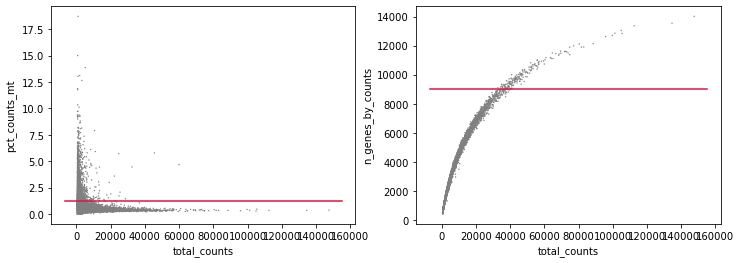

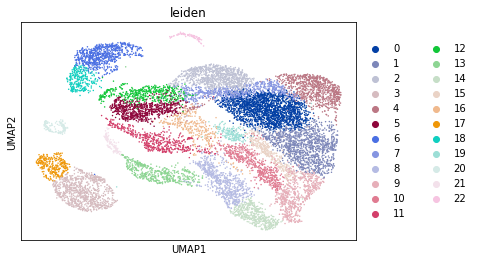

In [28]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
min_genes = int(numpy.round(encode_full.shape[1] * .01))
min_cells = int(numpy.round(encode_full.shape[0] * .01))
print("min_genes", min_genes)
print("min_cells", min_cells)

scanpy.pp.filter_cells(encode_full, min_genes=min_genes)
scanpy.pp.filter_genes(encode_full, min_cells=min_cells)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 1 * stdev
mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["n_genes_by_counts"])
n_genes = mean + 3 * stdev
print("pct_mt", pct_mt)
print("n_genes", n_genes)


f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (pct_mt, pct_mt), color="#DC143C")
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (n_genes, n_genes), color="#DC143C")


hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)

hist_filtered.raw = hist_filtered

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

min_genes 192
min_cells 157
pct_mt 1.2304862835805948
n_genes 11891.945965430947


/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


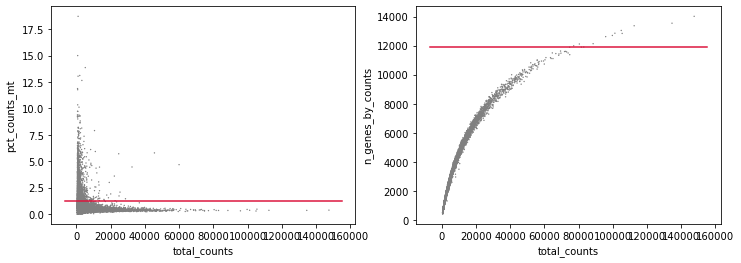

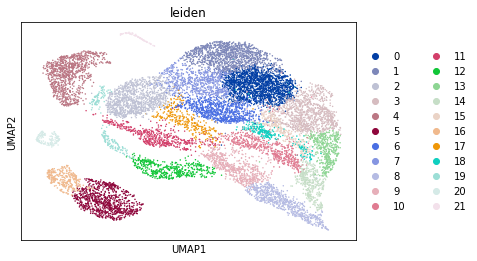

In [29]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
min_genes = int(numpy.round(encode_full.shape[1] * .01))
min_cells = int(numpy.round(encode_full.shape[0] * .01))
print("min_genes", min_genes)
print("min_cells", min_cells)

scanpy.pp.filter_cells(encode_full, min_genes=min_genes)
scanpy.pp.filter_genes(encode_full, min_cells=min_cells)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 1 * stdev
mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["n_genes_by_counts"])
n_genes = mean + 4 * stdev
print("pct_mt", pct_mt)
print("n_genes", n_genes)


f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (pct_mt, pct_mt), color="#DC143C")
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (n_genes, n_genes), color="#DC143C")


hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)

hist_filtered.raw = hist_filtered

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

min_genes 192
min_cells 157
pct_mt 1.2304862835805948


/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


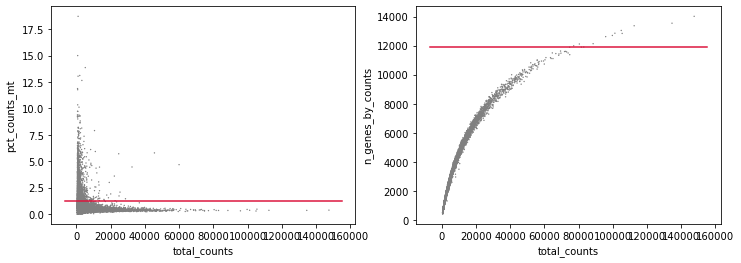

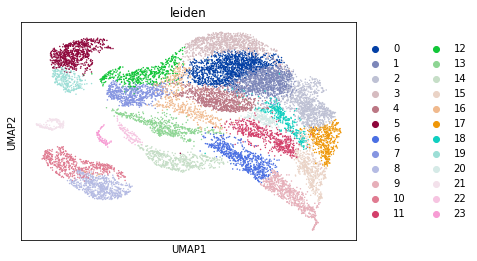

In [30]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
min_genes = int(numpy.round(encode_full.shape[1] * .01))
min_cells = int(numpy.round(encode_full.shape[0] * .01))
print("min_genes", min_genes)
print("min_cells", min_cells)

scanpy.pp.filter_cells(encode_full, min_genes=min_genes)
scanpy.pp.filter_genes(encode_full, min_cells=min_cells)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 1 * stdev
#mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["n_genes_by_counts"])
#n_genes = mean + 3 * stdev
print("pct_mt", pct_mt)
#print("n_genes", n_genes)


f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (pct_mt, pct_mt), color="#DC143C")
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (n_genes, n_genes), color="#DC143C")


#hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = encode_full.copy()
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)

hist_filtered.raw = hist_filtered

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

min_genes 192
min_cells 157
pct_mt 1.2304862835805948


/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


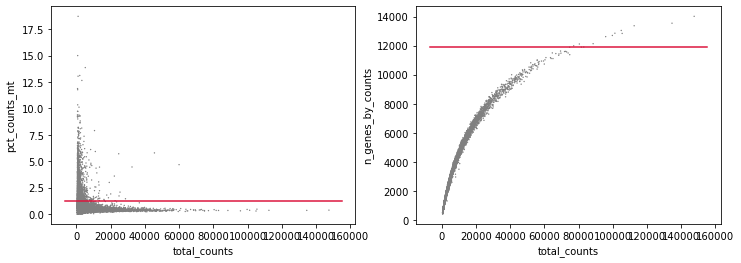

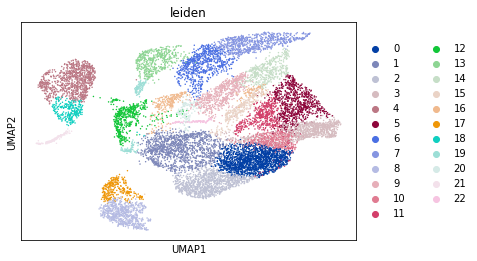

In [31]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
min_genes = int(numpy.round(encode_full.shape[1] * .01))
min_cells = int(numpy.round(encode_full.shape[0] * .01))
print("min_genes", min_genes)
print("min_cells", min_cells)

scanpy.pp.filter_cells(encode_full, min_genes=min_genes)
scanpy.pp.filter_genes(encode_full, min_cells=min_cells)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 1 * stdev
#mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["n_genes_by_counts"])
#n_genes = mean + 3 * stdev
print("pct_mt", pct_mt)
#print("n_genes", n_genes)


f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (pct_mt, pct_mt), color="#DC143C")
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (n_genes, n_genes), color="#DC143C")


#hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = encode_full.copy()
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)
#scanpy.pl.highly_variable_genes(hist_filtered)
hist_filtered.raw = hist_filtered
scanpy.pp.highly_variable_genes(hist_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
hist_filtered = hist_filtered[:, hist_filtered.var.highly_variable]
hist_filtered.raw = hist_filtered

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

min_genes 192
min_cells 157
pct_mt 1.2304862835805948


/usr/lib/python3/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


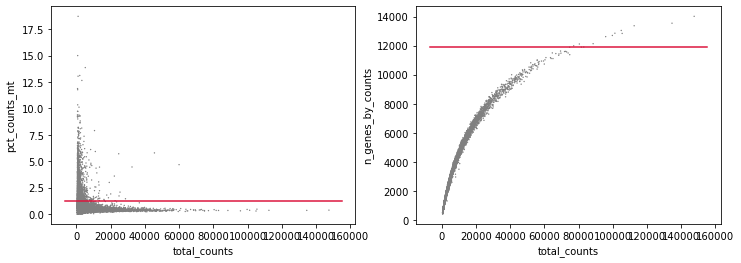

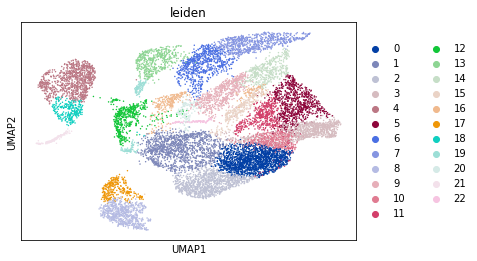

In [32]:
#scanpy.pl.highest_expr_genes(encode_full, n_top=20, gene_symbols='gene_name')
min_genes = int(numpy.round(encode_full.shape[1] * .01))
min_cells = int(numpy.round(encode_full.shape[0] * .01))
print("min_genes", min_genes)
print("min_cells", min_cells)

scanpy.pp.filter_cells(encode_full, min_genes=min_genes)
scanpy.pp.filter_genes(encode_full, min_cells=min_cells)
encode_full.var['mt'] = encode_full.var['gene_name'].str.startswith("MT-")
scanpy.pp.calculate_qc_metrics(encode_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["pct_counts_mt"])
pct_mt = mean + 1 * stdev
#mean, stdev = scipy.stats.halfnorm.fit(encode_full.obs["n_genes_by_counts"])
#n_genes = mean + 3 * stdev
print("pct_mt", pct_mt)
#print("n_genes", n_genes)


f = pyplot.figure(figsize=(12,4))
ax = f.add_subplot(1,2,1)
scanpy.pl.scatter(encode_full, x='total_counts', y='pct_counts_mt', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (pct_mt, pct_mt), color="#DC143C")
ax = f.add_subplot(1,2,2)
_ = scanpy.pl.scatter(encode_full, x='total_counts', y='n_genes_by_counts', ax=ax, show=False)
x = ax.get_xlim()
ax.plot(x, (n_genes, n_genes), color="#DC143C")


#hist_filtered = encode_full[encode_full.obs.n_genes_by_counts < n_genes, :]
hist_filtered = encode_full.copy()
hist_filtered = hist_filtered[hist_filtered.obs.pct_counts_mt < pct_mt, :]

#scanpy.pp.normalize_total(hist_filtered, target_sum=30000)
scanpy.pp.log1p(hist_filtered)
#scanpy.pl.highly_variable_genes(hist_filtered)
hist_filtered.raw = hist_filtered
scanpy.pp.highly_variable_genes(hist_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
hist_filtered = hist_filtered[:, hist_filtered.var.highly_variable]
hist_filtered.raw = hist_filtered

#scanpy.pp.scale(hist_filtered, max_value=10)
scanpy.tl.pca(hist_filtered, svd_solver='arpack')
#scanpy.pl.pca(hist_filtered)

scanpy.pp.neighbors(hist_filtered, n_neighbors=10, n_pcs=40)
scanpy.tl.umap(hist_filtered)

scanpy.tl.leiden(hist_filtered)
scanpy.pl.umap(hist_filtered, color=['leiden'])

/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored

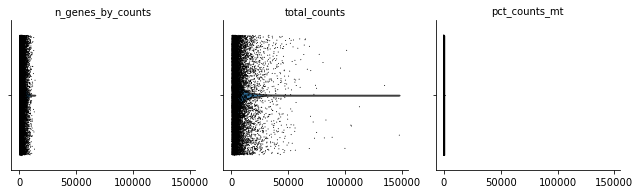

In [62]:
scanpy.pl.violin(
    encode_full,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True, show=False)

/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/lib/python3/dist-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored

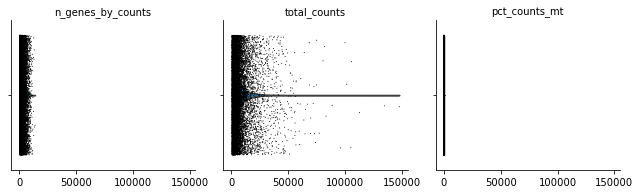

In [61]:
scanpy.pl.violin(
    encode_full, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], use_raw=False,
             jitter=0.4, multi_panel=True)

In [57]:
from anndata import AnnData
from typing import Union, Sequence, Optional, Literal
from matplotlib.axes import Axes
from scanpy._utils import sanitize_anndata
from scanpy import get
from collections import OrderedDict
import pandas as pd

def my_violin(
    adata: AnnData,
    keys: Union[str, Sequence[str]],
    groupby: Optional[str] = None,
    log: bool = False,
    use_raw: Optional[bool] = None,
    stripplot: bool = True,
    jitter: Union[float, bool] = True,
    size: int = 1,
    layer: Optional[str] = None,
    scale: Literal['area', 'count', 'width'] = 'width',
    order: Optional[Sequence[str]] = None,
    multi_panel: Optional[bool] = None,
    xlabel: str = '',
    ylabel: Optional[Union[str, Sequence[str]]] = None,
    rotation: Optional[float] = None,
    show: Optional[bool] = None,
    save: Union[bool, str, None] = None,
    ax: Optional[Axes] = None,
    **kwds,
):
    """\
    Violin plot.

    Wraps :func:`seaborn.violinplot` for :class:`~anndata.AnnData`.

    Parameters
    ----------
    adata
        Annotated data matrix.
    keys
        Keys for accessing variables of `.var_names` or fields of `.obs`.
    groupby
        The key of the observation grouping to consider.
    log
        Plot on logarithmic axis.
    use_raw
        Whether to use `raw` attribute of `adata`. Defaults to `True` if `.raw` is present.
    stripplot
        Add a stripplot on top of the violin plot.
        See :func:`~seaborn.stripplot`.
    jitter
        Add jitter to the stripplot (only when stripplot is True)
        See :func:`~seaborn.stripplot`.
    size
        Size of the jitter points.
    layer
        Name of the AnnData object layer that wants to be plotted. By
        default adata.raw.X is plotted. If `use_raw=False` is set,
        then `adata.X` is plotted. If `layer` is set to a valid layer name,
        then the layer is plotted. `layer` takes precedence over `use_raw`.
    scale
        The method used to scale the width of each violin.
        If 'width' (the default), each violin will have the same width.
        If 'area', each violin will have the same area.
        If 'count', a violin’s width corresponds to the number of observations.
    order
        Order in which to show the categories.
    multi_panel
        Display keys in multiple panels also when `groupby is not None`.
    xlabel
        Label of the x axis. Defaults to `groupby` if `rotation` is `None`,
        otherwise, no label is shown.
    ylabel
        Label of the y axis. If `None` and `groupby` is `None`, defaults
        to `'value'`. If `None` and `groubpy` is not `None`, defaults to `keys`.
    rotation
        Rotation of xtick labels.
    {show_save_ax}
    **kwds
        Are passed to :func:`~seaborn.violinplot`.

    Returns
    -------
    A :class:`~matplotlib.axes.Axes` object if `ax` is `None` else `None`.

    Examples
    --------

    .. plot::
        :context: close-figs

        import scanpy as sc
        adata = sc.datasets.pbmc68k_reduced()
        sc.pl.violin(adata, keys='S_score')

    Plot by category. Rotate x-axis labels so that they do not overlap.

    .. plot::
        :context: close-figs

        sc.pl.violin(adata, keys='S_score', groupby='bulk_labels', rotation=90)

    Set order of categories to be plotted or select specific categories to be plotted.

    .. plot::
        :context: close-figs

        groupby_order = ['CD34+', 'CD19+ B']
        sc.pl.violin(adata, keys='S_score', groupby='bulk_labels', rotation=90,
            order=groupby_order)

    Plot multiple keys.

    .. plot::
        :context: close-figs

        sc.pl.violin(adata, keys=['S_score', 'G2M_score'], groupby='bulk_labels',
            rotation=90)

    For large datasets consider omitting the overlaid scatter plot.

    .. plot::
        :context: close-figs

        sc.pl.violin(adata, keys='S_score', stripplot=False)

    .. currentmodule:: scanpy

    See also
    --------
    pl.stacked_violin
    """
    import seaborn as sns  # Slow import, only import if called

    sanitize_anndata(adata)
    use_raw = False #_check_use_raw(adata, use_raw)
    if isinstance(keys, str):
        keys = [keys]
    keys = list(OrderedDict.fromkeys(keys))  # remove duplicates, preserving the order

    if isinstance(ylabel, (str, type(None))):
        ylabel = [ylabel] * (1 if groupby is None else len(keys))
    if groupby is None:
        if len(ylabel) != 1:
            raise ValueError(
                f'Expected number of y-labels to be `1`, found `{len(ylabel)}`.'
            )
    elif len(ylabel) != len(keys):
        raise ValueError(
            f'Expected number of y-labels to be `{len(keys)}`, '
            f'found `{len(ylabel)}`.'
        )

    if groupby is not None:
        obs_df = get.obs_df(adata, keys=[groupby] + keys, layer=layer, use_raw=use_raw)
        if kwds.get('palette', None) is None:
            if not is_categorical_dtype(adata.obs[groupby]):
                raise ValueError(
                    f'The column `adata.obs[{groupby!r}]` needs to be categorical, '
                    f'but is of dtype {adata.obs[groupby].dtype}.'
                )
            _utils.add_colors_for_categorical_sample_annotation(adata, groupby)
            kwds['palette'] = dict(
                zip(obs_df[groupby].cat.categories, adata.uns[f'{groupby}_colors'])
            )
    else:
        obs_df = get.obs_df(adata, keys=keys, layer=layer, use_raw=use_raw)
    if groupby is None:
        obs_tidy = pd.melt(obs_df, value_vars=keys)
        x = 'variable'
        ys = ['value']
    else:
        obs_tidy = obs_df
        x = groupby
        ys = keys

    if multi_panel and groupby is None and len(ys) == 1:
        # This is a quick and dirty way for adapting scales across several
        # keys if groupby is None.
        y = ys[0]

        g = sns.catplot(
            y=y,
            data=obs_tidy,
            kind="violin",
            scale=scale,
            col=x,
            col_order=keys,
            sharey=False,
            order=keys,
            cut=0,
            inner=None,
            **kwds,
        )

        if stripplot:
            grouped_df = obs_tidy.groupby(x)
            for ax_id, key in zip(range(g.axes.shape[1]), keys):
                sns.stripplot(
                    y=y,
                    data=grouped_df.get_group(key),
                    jitter=jitter,
                    size=size,
                    color="black",
                    ax=g.axes[0, ax_id],
                )
        if log:
            g.set(yscale='log')
        g.set_titles(col_template='{col_name}').set_xlabels('')
        if rotation is not None:
            for ax in g.axes[0]:
                ax.tick_params(axis='x', labelrotation=rotation)
    else:
        # set by default the violin plot cut=0 to limit the extend
        # of the violin plot (see stacked_violin code) for more info.
        kwds.setdefault('cut', 0)
        kwds.setdefault('inner')

        if ax is None:
            axs, _, _, _ = setup_axes(
                ax=ax,
                panels=['x'] if groupby is None else keys,
                show_ticks=True,
                right_margin=0.3,
            )
        else:
            axs = [ax]
        for ax, y, ylab in zip(axs, ys, ylabel):
            ax = sns.violinplot(
                x=x,
                y=y,
                data=obs_tidy,
                order=order,
                orient='vertical',
                scale=scale,
                ax=ax,
                **kwds,
            )
            if stripplot:
                ax = sns.stripplot(
                    x=x,
                    y=y,
                    data=obs_tidy,
                    order=order,
                    jitter=jitter,
                    color='black',
                    size=size,
                    ax=ax,
                )
            if xlabel == '' and groupby is not None and rotation is None:
                xlabel = groupby.replace('_', ' ')
            ax.set_xlabel(xlabel)
            if ylab is not None:
                ax.set_ylabel(ylab)

            if log:
                ax.set_yscale('log')
            if rotation is not None:
                ax.tick_params(axis='x', labelrotation=rotation)
    show = False #settings.autoshow if show is None else show
    #_utils.savefig_or_show('violin', show=show, save=save)
    if not show:
        if multi_panel and groupby is None and len(ys) == 1:
            return g
        elif len(axs) == 1:
            return axs[0]
        else:
            return axs


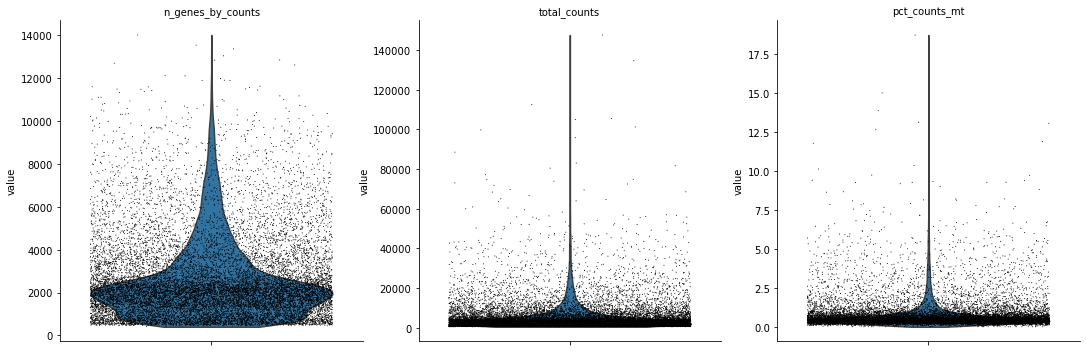

In [58]:
my_violin(
    encode_full, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [63]:
scanpy.__version__

'1.6.0'